In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# Define the class names
class_names = ['Not Pneumonic', 'Pneumonic']

# Define the preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the image
image_path = '/content/423147679_411405174709485_8284101553511391454_n.jpg'
image = Image.open(image_path)
image = image.convert('RGB')

# Apply the preprocessing transformation
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# Load the model

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/try2_model.pth', map_location = torch.device('cpu')))
model.eval()

# Perform inference
with torch.no_grad():
    output = model(input_batch)
    probabilities = torch.sigmoid(output)
    predicted_class = torch.round(probabilities).squeeze().int().item()

# Print the prediction
print('Predicted Class:', class_names[predicted_class])
print('Probability:', float(probabilities.item()))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


Predicted Class: Not Pneumonic
Probability: 8.559511115890928e-06


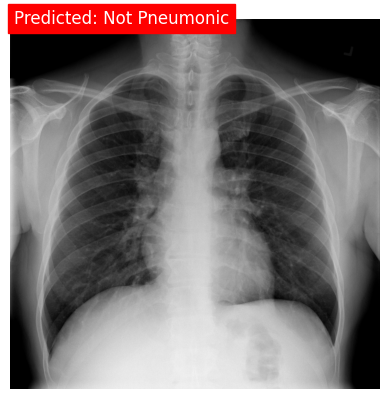

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {class_names[predicted_class]}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-5-d2cbf03ce6f2>:74: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cam_features = np.uint8(Image.fromarray(cam_features).resize((224, 224), Image.ANTIALIAS))
<ipython-input-5-d2cbf03ce6f2>:78: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (20

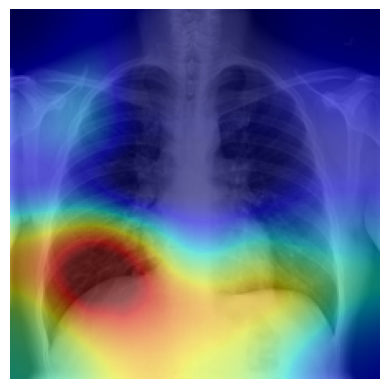

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the pretrained ResNet-18 model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/try2_model.pth', map_location = torch.device('cpu')))


# Define CAM module
class CAM(nn.Module):
    def __init__(self, model, target_layer):
        super(CAM, self).__init__()
        self.model = model
        self.target_layer = target_layer
        self.conv_activation = None
        self.model.eval()

        # Hook to retrieve convolutional feature maps
        self.hook = self.model.layer4.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.conv_activation = output

    def forward(self, x):
        _ = self.model(x)
        conv_activation = self.conv_activation
        self.conv_activation = None
        return conv_activation

# Instantiate CAM module
cam = CAM(model, 'layer4')

# Load and preprocess the image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

# Forward pass to obtain CAM
def generate_cam(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        features = cam(image)
        prediction = model(image)

    _, predicted_class = prediction.max(1)
    predicted_class = predicted_class.item()

    # Calculate CAM
    conv_activations = features.detach()
    weights = list(model.fc.parameters())[0].detach().unsqueeze(-1).unsqueeze(-1)
    cam_features = torch.sum(weights * conv_activations, dim=1)
    cam_features = torch.nn.functional.relu(cam_features).squeeze().cpu().numpy()


    # Normalize CAM
    cam_features -= np.min(cam_features)
    cam_features /= np.max(cam_features)

    # Resize CAM to match input image size
    cam_features = np.uint8(255 * cam_features)
    cam_features = np.uint8(Image.fromarray(cam_features).resize((224, 224), Image.ANTIALIAS))

    # Visualization
    original_image = Image.open(image_path).convert('RGB')
    original_image = np.array(original_image.resize((224, 224), Image.ANTIALIAS))
    plt.imshow(original_image)
    plt.imshow(cam_features, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()


# Example usage
# if class_names[predicted_class] == 'Pneumonic':
  #image_path = '/content/drive/MyDrive/Minor project/Dataset/Testing/Pneumonic/11a2e0cb-ee1f-4d53-a211-b8faff6bf888.jpg'
generate_cam(image_path)


Pneumonic 0.8095047473907471


C:\Users\ACER\AppData\Local\Temp\ipykernel_10760\2748435779.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_jet = cm.get_cmap('jet')


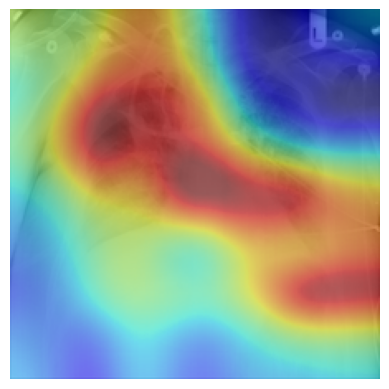

In [7]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# from PIL import Image
# import numpy as np
# import torch.nn as nn
# import torchvision.models as models
# import matplotlib.cm as cm
# from matplotlib.colors import Normalize
# from flask import Flask, request, jsonify, send_file, redirect
# import time
# from flask_cors import CORS
# import io
# import os


# app = Flask(_name_)
# CORS(app, supports_credentials=True, methods=["GET", "POST", "PUT", "DELETE"])

# # Define the class names
# class_names = ['Not Pneumonic', 'Pneumonic']

# # Define the preprocessing transformation
# def model_preprocess(image_path):
#   image = Image.open(image_path).convert("RGB")
#   preprocess_model = transforms.Compose([
#       transforms.Resize((224, 224)),
#       transforms.ToTensor(),
#       transforms.Normalize(mean=[0.5], std=[0.5])
#   ])
#   input_tensor = preprocess_model(image)
#   input_batch = input_tensor.unsqueeze(0)
#   return input_batch 

# # Load the model
# model = torchvision.models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = torch.nn.Linear(num_ftrs, 1)
# model.load_state_dict(torch.load("C:/Users/ACER/Machine Learning/cross_model1.pth", map_location = torch.device('cpu')))
# model.eval()

# # Define CAM module
# class CAM(nn.Module):
#     def __init__(self, model, target_layer):
#         super(CAM, self).__init__()
#         self.model = model
#         self.target_layer = target_layer
#         self.conv_activation = None
#         self.model.eval()

#         # Hook to retrieve convolutional feature maps
#         self.hook = self.model.layer4.register_forward_hook(self.hook_fn)

#     def hook_fn(self, module, input, output):
#         self.conv_activation = output

#     def forward(self, x):
#         _ = self.model(x)
#         conv_activation = self.conv_activation
#         self.conv_activation = None
#         return conv_activation

# # Instantiate CAM module
# cam = CAM(model, 'layer4')

# # Load and preprocess the image
# def preprocess_image(image_path):
#     preprocess = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
    
#     image = Image.open(image_path).convert('RGB')
#     image = preprocess(image).unsqueeze(0)
#     return image

# # Forward pass to obtain CAM
# def generate_and_save_cam(image_path, save_dir):
#     # Load and preprocess the image
#     # image = Image.open(image_path).convert('RGB')
#     # image = preprocess_image(image)
#     image = preprocess_image(image_path)
#     image1 = model_preprocess(image_path)
    
#     # Perform inference and get predicted class
#     with torch.no_grad():
#         features = cam(image)
#         output = model(image1) 
#         prediction_prob = torch.sigmoid(output).item()
#         # print(prediction_prob)
#         if prediction_prob >= 0.5:
#             predicted_class = 1
#         else:
#             predicted_class = 0

#     print(class_names[predicted_class],prediction_prob)

#     # Calculate CAM
#     conv_activations = features.detach()
#     weights = list(model.fc.parameters())[0].detach().unsqueeze(-1).unsqueeze(-1)
#     cam_features = torch.sum(weights * conv_activations, dim=1)
#     cam_features = torch.nn.functional.relu(cam_features).squeeze().cpu().numpy()

#     # Normalize CAM
#     cam_features -= np.min(cam_features)
#     cam_features /= np.max(cam_features)

#     # Resize CAM to match input image size
#     cam_features = np.uint8(255 * cam_features)
#     cam_features = np.uint8(Image.fromarray(cam_features).resize((224, 224), Image.LANCZOS))

#     # Load the X-ray image
#     original_image = Image.open(image_path).convert('RGBA')
#     original_image = original_image.resize((224, 224), Image.LANCZOS)

#     # Convert cam_features to a pseudo-color image using the 'jet' colormap
#     cmap_jet = cm.get_cmap('jet')
#     norm = Normalize(vmin=cam_features.min(), vmax=cam_features.max())
#     colored_cam_features = (cmap_jet(norm(cam_features)) * 255).astype(np.uint8)

#     # Convert the colored cam_features array to a PIL Image
#     cam_image = Image.fromarray(colored_cam_features)

#     # Blend the original image with the cam_image using alpha blending
#     blended_image = Image.blend(original_image, cam_image, alpha=0.5)


#     # Generate a unique filename for the processed image
#     filename = os.path.basename(image_path)
#     processed_image_name = f"{class_names[predicted_class]}.png"
#     save_path = os.path.join(save_dir, processed_image_name)

#     # Save the processed image with the unique filename
#     blended_image.save(save_path)
#     return save_path, class_names[predicted_class]
    

# @app.route("/predict", methods=["POST"])
# def prediction_route():
#     if 'file' not in request.files:
#         return "No file found", 400

#     file = request.files['file']
#     if file.filename == '':
#         return "No selected file", 400

#     if file:
#         filename = "upload.png"  # New filename for the uploaded image
#         filepath = os.path.join("uploads", filename)  # Construct the file path
#         file.save(filepath)
#         print("Image saved to:", filepath)  # Debugging

#         # Preprocess image and make prediction
#         image = preprocess_image(filepath)

#         # CAM MODEL LAI USE
#         processed_image_path= os.path.join("static", "predictions")
#         path,c_name=generate_and_save_cam(filepath, processed_image_path)
        
#         # Save processed image to static/predictions
        
#         # Image.fromarray((image.squeeze().permute(1, 2, 0).numpy() * 255).astype('uint8')).save(processed_image_path)

#         # Return the path to the processed image
#         return jsonify({"processed_image_path": processed_image_path,
#                        "c_name":c_name})

# def check_image(image_path):
#     return os.path.exists(image_path)

# @app.route('/image')
# def get_image():
#     # image_path = os.path.join(os.path.dirname(_file_), 'static', 'predictions', 'processed_image.png')
#     directory = "C:/minor project/static/predictions"
#     file_names = os.listdir(directory)
#     image_path=f"C:/minor project/static/predictions/{file_names[0]}"
    
#     try:
#         # Check if the image exists
#         if check_image(image_path):
#             # If the image exists, send it
#             return send_file(image_path)
#         else:
#             # If the image does not exist, wait and try again after a delay
#             time.sleep(2)  # Wait for 2 seconds before trying again
#             return jsonify('/image')
#     except Exception as e:
#         return str(e)
# @app.route('/get_text')
# def text():
#     directory = "C:/minor project/static/predictions"
#     file_names = os.listdir(directory)
#     image_path=f"C:/minor project/static/predictions/{file_names[0]}"
#     return jsonify({'c_name':file_names[0]})

# @app.route('/delete-image', methods=['DELETE'])
# def delete_image():
#     directory = "C:/minor project/static/predictions"
#     file_names = os.listdir(directory)
#     try:
#         os.remove(f"C:/minor project/static/predictions/{file_names[0]}")
#         return jsonify({'message': 'Image deleted successfully'})
#     except Exception as e:
#         return jsonify({'error': str(e)}), 500
    

# if _name_ == "_main_":
#     app.run(host='localhost', port=8000)